# Bayesian Networks - K2 algorithm


In [2]:
library("dplyr")
library("igraph")
library("bnstruct")

## Graph representation function

In order to visualize the DAGs, we implement a function that receives as input a list of the parents and returns the graph.

In [3]:
plot_BN <- function(papitos, labels=NULL){
    
    #Create an "edge list matrix" ---> https://igraph.org/r/doc/graph_from_edgelist.html
    
    outgoing <- c()
    incoming <- c()
    for(i in 1:length(papitos)){
        for(j in papitos[[i]]){
            outgoing <- c(outgoing, as.character(j))
            incoming <- c(incoming, as.character(i))
            
        }
    }
    edge_list_matrix <- t(rbind(outgoing, incoming)) #transpose    
    
    network <- graph_from_edgelist(edge_list_matrix, directed=TRUE)
    par(bg="beige")
    igraph::plot.igraph(network, 
                                layout=layout.fruchterman.reingold,
                                vertex.color = rgb(0.7,0.1,0.9),
                                vertex.label.font=5,
                                vertex.label.cex = 1.9,
                                vertex.frame.color = "white",                 
                                vertex.shape="square",                        
                                vertex.size=25,                               
                                vertex.label.color="white", 
                                edge.width=3,
                                edge.color='black',
                                edge.arrow.size=1,
                                edge.arrow.width=1,
                                edge.curved=0.25)
        title("Learned Bayesian Network", cex.main=2,col.main="black")
        if (!is.null(labels)){legend("bottomright", labels)}
}

## K2 Main Algorithm 

1. Set of nodes *Z*
2. Ordering of the nodes
3. Upper bound on the number of parents (for each node) *u*
4. Database *D* of m cases

In [4]:
# Function to compute a matrix with the number of cases in D in which a given attribute is intantiated with its k-th value
# and its parents have the j-th instantation.
N_tensor <- function(D, i, V.i, pi.i){
    result <- D %>% count(D[,pi.i], name='j_counts')
    if (length(pi.i) == 1){colnames(result)[1] <- 'j'}
        for (k in V.i){
            k_count <- D[D[, i]==k,] %>% count(D[D[, i]==k,pi.i])
            if (length(pi.i) == 1){colnames(k_count)[1] <- 'j'}
            colnames(k_count)[length(colnames(k_count))]<- k
            result <- merge(result, k_count, all.x=TRUE) 
        }
        result[is.na(result)] <- 0
    return(result)
}

# Probability function
g <- function(V.i, r.i, N.tensor){
    N.ij <- N.tensor$j_counts
    q.i <- length(N.ij) # number of unique combinations of the parents realizations
    result <- 1
    for (j in 1:q.i) {
        a <- 1
        for (k in V.i){a <- a*factorial(N.tensor[j,as.character(k)])}
        result <- result*a*factorial(r.i-1)/factorial(N.ij[j]+r.i-1)
    }
    return(result)
}

# Main algorithm
k2 <- function(Z, u, D){
    V <- unname(sapply(D, unique)) #it's a matrix or a list
    r <- unname(sapply(D, n_distinct)) #it's a vector
    parents <- list()
    for (i in 1:length(Z)){
        pi.i <- NULL 
        Nijk <- N_tensor(D, Z[i], V[,i], pi.i)
        P_old <- g(V[,i],r[i], Nijk)
        proceed <- TRUE
        changed <- FALSE
        while (proceed & (length(pi.i)<u & i>1)){
            pred.i <- setdiff(Z[1:i-1], pi.i)
            P <- 0
            for (node in pred.i){
                new_set <- union(pi.i, node)
                Nijk <- N_tensor(D, Z[i], V[,i], new_set)
                P <- g(V[,i], r[i], Nijk)
                if (P > P_old){
                    P_old <- P
                    temp.pi <- new_set
                    changed <- TRUE
                }
            }
            if (changed != TRUE){
                proceed <- FALSE
            } else{
                pi.i <- temp.pi
                changed <- FALSE
            }
        }
        parents <- append(parents, list(pi.i))
    } 
    return(parents)
}


## Test on dummy datasets

### 3 nodes

In [5]:
x1 <- c(1,1,0,1,0,0,1,0,1,0)
x2 <- c(0,1,0,1,0,1,1,0,1,0)
x3<- c(0,1,1,1,0,1,1,0,1,0)

toy.3nodes <- data.frame(x1, x2, x3)

print(toy.3nodes)

   x1 x2 x3
1   1  0  0
2   1  1  1
3   0  0  1
4   1  1  1
5   0  0  0
6   0  1  1
7   1  1  1
8   0  0  0
9   1  1  1
10  0  0  0


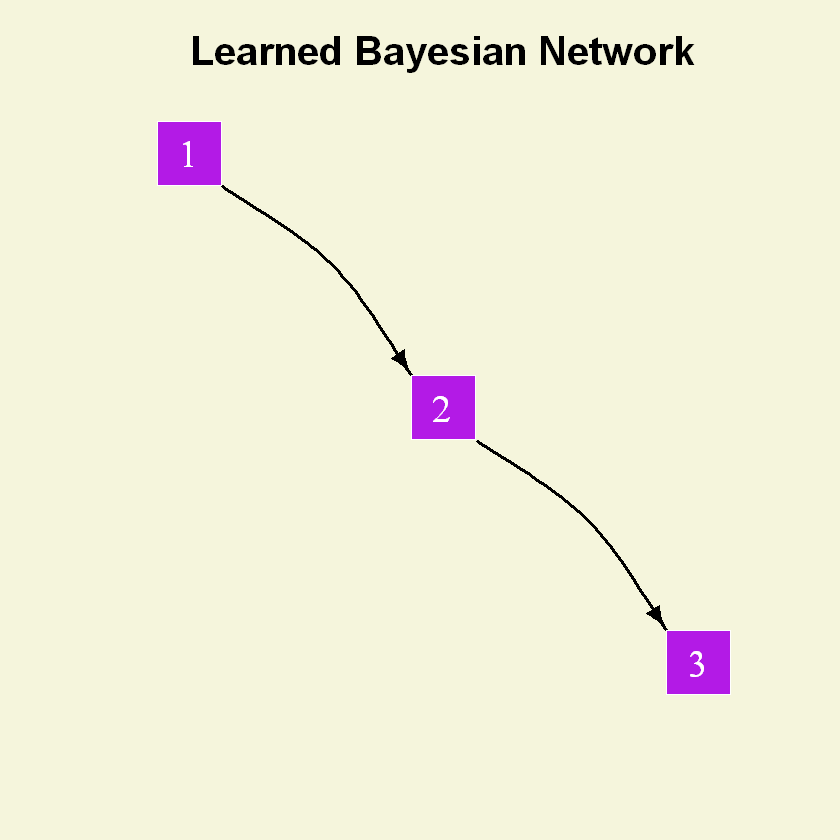

In [6]:
parents <- k2(c(1,2,3), u=3, toy.3nodes)
plot_BN(parents)

#### Comparison with Bnstruct

In [7]:
# Create the BNDatset
toy.BN3 <- BNDataset(data = matrix(c(x1, x2, x3), ncol = 3),
                    discreteness = rep('d',3),
                    variables = c('x1','x2','x3'))
typeof(toy.BN3)

Warning message in BNDataset(data = matrix(c(x1, x2, x3), ncol = 3), discreteness = rep("d", :
"Variable cardinalities guessed from data. Please check for consistency with your actual data. Otherwise, execution may terminate with errors later."

[1] "S4"

In [8]:
# Find the graph
learn.network(toy.BN3)

bnstruct :: learning the structure using MMHC ...


ERROR: Error in if (dim(data)[1]/prod(sizes[c(x, y, z)]) < min.counts) return(chi.th): valor ausente donde TRUE/FALSE es necesario


### 15 nodes

In [9]:
m=100
L=15
data<- sample(0:1,replace=TRUE, size=m*L)
dim(data)<-c(m,L)
toy.15nodes <- data.frame(data)

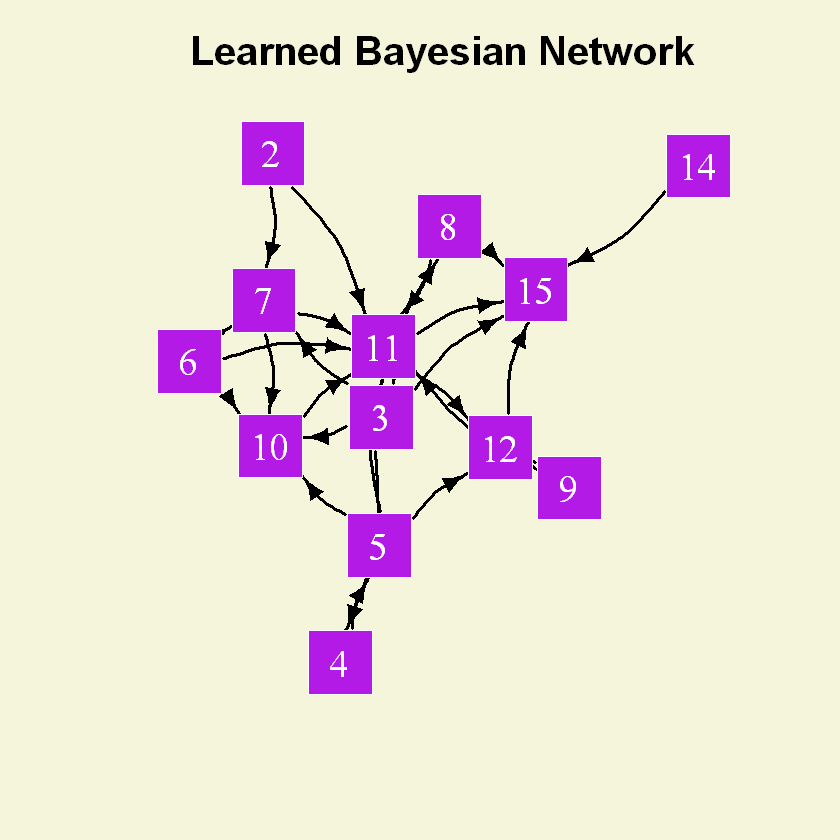

In [10]:
parents <- k2(1:L, u=10, toy.15nodes)
plot_BN(parents)

#### Comparison with BNStruct

In [19]:
toy.BN15 <- BNDataset(data = data.matrix(data),
                    discreteness = rep('d',L),
                    variables = LETTERS[1:L])

Warning message in BNDataset(data = data.matrix(data), discreteness = rep("d", L), :
"Variable cardinalities guessed from data. Please check for consistency with your actual data. Otherwise, execution may terminate with errors later."

In [20]:
# Find the graph
DAG15 <- learn.network(toy.BN3)

... bnstruct :: learning the structure using MMHC ...


ERROR: Error in if (dim(data)[1]/prod(sizes[c(x, y, z)]) < min.counts) return(chi.th): valor ausente donde TRUE/FALSE es necesario


## K2 Algorithm - log imlementation

The algorithm perform several factorial functions, which can be problematic and time and memory consuming when dealing with large datasets. We present a common solution, by taking the logarithm of the factorials and using the Stirling approximation, the problem is solved.

In [21]:
# Stirling apporx for large numbers
log_factorial <- function(N){
    if(N > 15){return(N*log(N)-N)}
    else if(N==0){return(0)}
    else{return(log(factorial(N)))}
}

# Logarithmic probability function
g_log <- function(V.i, r.i, N.tensor){
    N.ij <- N.tensor$j_counts
    q.i <- length(N.ij) # number of unique combinations of the parents realizations
    result <- 0
    for (j in 1:q.i) {
        a <- 0
        for (k in V.i){a <- a+log_factorial(N.tensor[j,as.character(k)])}
        result <- result+a+log_factorial(r.i-1)-log_factorial(N.ij[j]+r.i-1)
    }
    return(result)
}

# K2 logarithmic algorithm
k2_log <- function(Z, u, D){
    V <- unname(sapply(D, unique)) #it's a matrix or a list
    r <- unname(sapply(D, n_distinct)) #it's a vector
    parents <- list()
    for (i in 1:length(Z)){
        pi.i <- NULL 
        Nijk <- N_tensor(D, Z[i], V[[i]], pi.i)
        P_old <- g_log(V[[i]],r[i], Nijk)
        proceed <- TRUE
        changed <- FALSE
        while (proceed & (length(pi.i)<u & i>1)){
            pred.i <- setdiff(Z[1:i-1], pi.i)
            P <- 0
            for (node in pred.i){
                new_set <- union(pi.i, node)
                Nijk <- N_tensor(D, Z[i], V[[i]], new_set)
                P <- g_log(V[[i]], r[i], Nijk)
                if (P > P_old){
                    P_old <- P
                    temp.pi <- new_set
                    changed <- TRUE
                }
            }
            if (changed != TRUE){
                proceed <- FALSE
            } else{
                pi.i <- temp.pi
                changed <- FALSE
            }
        }
        parents <- append(parents, list(pi.i))
    } 
    return(parents)
}

## Testing on an actual Dataset

##### Breast Cancer Diagnostic

   Attribute   Domain
   - Clump Thickness               1 - 10
   - Uniformity of Cell Size       1 - 10
   - Uniformity of Cell Shape      1 - 10
   - Marginal Adhesion             1 - 10
   - Single Epithelial Cell Size   1 - 10
   - Bare Nuclei                   1 - 10
   - Bland Chromatin               1 - 10
   - Normal Nucleoli               1 - 10
   - Mitoses                       1 - 10
   - Class:                        (2 for benign, 4 for malignant)

In [22]:
bc.labels <- c('1: Clump Thickness','2: Uniformity of Cell Size','3: Uniformity of Cell Shape','4: Marginal Adhesion','5: Single Epithelial Cell Size','6: Bare Nuclei','7: Bland Chromatin','8: Normal Nucleoli','9: Mitoses','10: Class')

In [23]:
data<-read.csv("breast-cancer.txt")[,-1]
breast_cancer_df<-data[data$Bare_Nuclei %in% 1:10, ]
breast_cancer_df<-transform(breast_cancer_df, Bare_Nuclei = as.integer(Bare_Nuclei))
head(breast_cancer_df)

Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
5,1,1,1,2,2,3,1,1,2
5,4,4,5,7,3,3,2,1,2
3,1,1,1,2,4,3,1,1,2
6,8,8,1,3,6,3,7,1,2
4,1,1,3,2,2,3,1,1,2
8,10,10,8,7,3,9,7,1,4


In [24]:
parents <- k2_log(1:length(breast_cancer_df), u=10, breast_cancer_df)

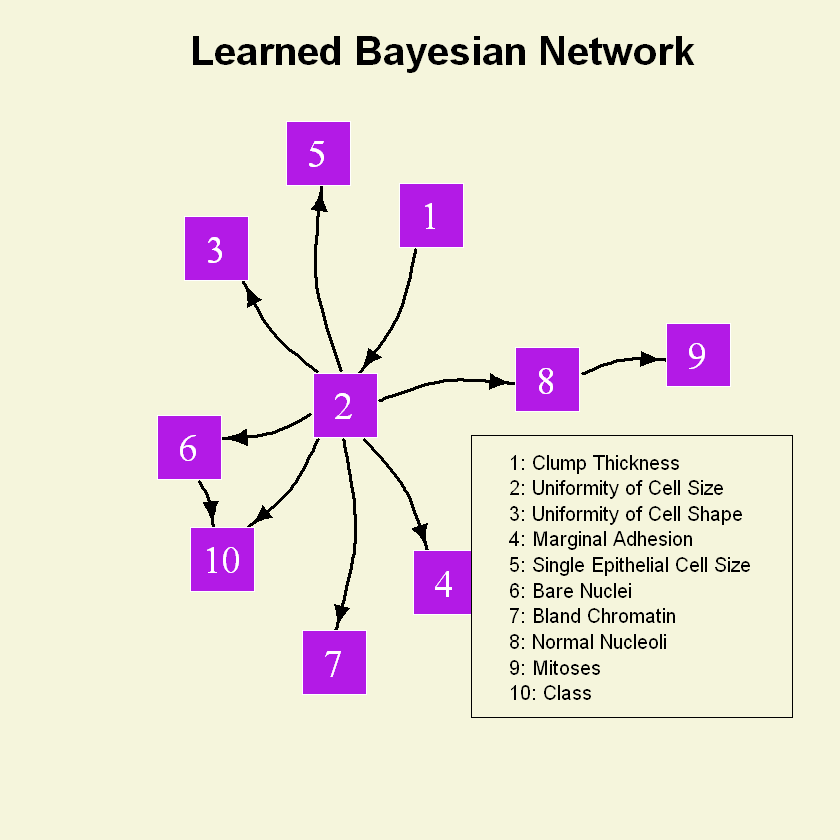

In [62]:
plot_BN(parents, bc.labels)

### Comparison with BNStruct

In [26]:
bc.BN <- BNDataset(data = data.matrix(breast_cancer_df),
                  discretenes = rep('d', length(bc.labels)),
                  variables = bc.labels)
bc.BN

Warning message in BNDataset(data = data.matrix(breast_cancer_df), discretenes = rep("d", :
"Variable cardinalities guessed from data. Please check for consistency with your actual data. Otherwise, execution may terminate with errors later."


Dataset: 

num.variables 10

variables
1: Clump Thickness 2: Uniformity of Cell Size 3: Uniformity of Cell Shape 4: Marginal Adhesion 5: Single Epithelial Cell Size 6: Bare Nuclei 7: Bland Chromatin 8: Normal Nucleoli 9: Mitoses 10: Class
discreteness
TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
node.sizes
0
num.items
683
imputation
FALSE
has.boots
FALSE
has.imputed.boots
FALSE
num.boots
0

In [27]:
learn.network(bc.BN)

... ... bnstruct :: learning the structure using MMHC ...


ERROR: Error in if (dim(data)[1]/prod(sizes[c(x, y, z)]) < min.counts) return(chi.th): valor ausente donde TRUE/FALSE es necesario
